# Clustering LC-MS data using UMAP


UMAP is a strong tool to reduce the dimensions of multi-dimensional datasets as it preserves much of the global structure of the actual data.

In this project I want to use UMAP to cluster LC-MS (liquid chromatography-mass spectrometry) data. The data was generated by treating T. gondii parasites with eight different inhibitors (2-deoxyglucose, 3-Bromopyruvate, BH388, buthionine sulfoximine, fosmidomycin, HDQ, ML304 and Oligomycin), extracting the metabolites of treated parasites and measuring these solutions with LC-MS. Log2 fold-changes between treated parasites and untreated parasites were calculated and the resulting dataset contains of log2 fold-changes of 248 metabolites for 128 samples (16 replicates for each inhibitor).

The dataset was clustered previously by my collegue using PCA and tSNE, which revealed clearly distinguishible clusters for each inhibitor treatment, leading to the assumption that most if not all of these inhibitors exhibit a unique metabolic fingerprint in T. gondii parasites. Even though PCA and tSNE present good algorithms for clustering data, it is said that UMAP does an even better job at preserving the original, global structure of the dataset. Therefore, I try to cluster this data in UMAP in this project. 

### 2D clustering

For 2D clustering I used the penguin data example by UMAP as an orientation. You can find this example here:
https://umap-learn.readthedocs.io/en/latest/basic_usage.html
I further used some code from stackoverflow etc. and changed it to fit my program.

First, I import all the libraries I need. These include pandas to work with dataframes and the excel table in which the dataset is stored, numpy to work with arrays, matplotlib.pyplot and seborn for data visualization, umap and the train_test_split module from skikitlearn, to later split up data in train and test samples.

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import umap
import os

Next, the excel table needs to be read and converted to a pandas dataframe. To get an idea of what that table looks like, the dataframe is printed, as well as its shape. 

In [102]:
df = pd.read_excel(r"~/Desktop/Maxidata.xlsx", header = 0) #header=0 makes the first row of the excel table the header

print(df)

print(df.shape)

    Name         1         2         3         4         5         6  \
0    2DG  0.247339  0.581519 -0.121081  0.528292 -0.026037  0.816245   
1    2DG  0.830483  1.452634  0.362974  0.173669 -1.653001  0.455910   
2    2DG  0.004769  0.992076 -0.121081 -0.344513 -2.034794  0.286801   
3    2DG  0.053563  0.668557 -0.121081 -0.014858 -1.771713  0.455910   
4    2DG  0.499963  0.581519 -0.121081 -0.068696 -0.739279  0.433488   
..   ...       ...       ...       ...       ...       ...       ...   
123  Oli  0.194759  1.640677  5.247023  0.959696 -0.219262 -2.010930   
124  Oli  0.714791  0.971981  5.247023  0.481503 -0.397849  1.463549   
125  Oli -0.459082  1.007557  5.247023  0.328355 -0.199235  0.628257   
126  Oli -0.043796  1.265905  5.247023  0.852701 -0.067332  0.515305   
127  Oli  0.181089  1.568949  5.247023  0.928016  0.473604  0.989655   

            7         8         9  ...       239       240       241  \
0    0.610402 -0.103883 -0.289395  ...  0.432483 -1.465049 -0.6

As you can see, the data has 128 rows, 16 for each of the 8 inhibitors. It also has 249 columns, the first column being the inhibitor name. Originially, the respective batch and replicate number of each sample was included in the name, but I changed that for more simplicity in the code later on. The names of the metabolites were also changed to numbers from 1 to 248 for the sake of simplicity.

Each metabolite's log2 fold-change for the respective inhibitor makes up one dimension of the data, meaning the data has 248 dimensions, which are going to be reduced to two using UMAP. 

Next, a list is created with the numbers of 1 to 248. Then, a dataframe called maxidata is created, consisting of all values in the columns of metabolite 1 to 248 of our dataframe df. 

In [103]:
List=[]
for x in range(1,249):
    List.append(x)

maxidata=df[List].values
print(maxidata.shape)
print(maxidata)

(128, 248)
[[ 2.47338962e-01  5.81518827e-01 -1.21081323e-01 ... -3.95258732e-01
  -1.48040172e-01  1.57915414e-01]
 [ 8.30482579e-01  1.45263379e+00  3.62973672e-01 ...  1.63045976e-01
   1.15697180e-01  1.21918267e+00]
 [ 4.76918730e-03  9.92076228e-01 -1.21081323e-01 ... -7.22989873e-01
  -3.92261923e-01  1.57915414e-01]
 ...
 [-4.59082475e-01  1.00755735e+00  5.24702312e+00 ... -1.13479442e+00
  -9.14272762e-01  9.10300332e-01]
 [-4.37955884e-02  1.26590506e+00  5.24702312e+00 ... -1.13479442e+00
  -1.16317253e+00  9.46108856e-01]
 [ 1.81088699e-01  1.56894923e+00  5.24702312e+00 ... -1.13479442e+00
  -1.42099333e+00  1.02131226e+00]]


The shape of the new maxidata indicates that the first column with the inhibitor names is now excluded.

This maxidata dataframe with 248 dimensions is now going to be reduced to 2 dimensions. For that, a reducer has to be defined with umap. In this reducer definitions, several hyperparameters can be individually changed depending on how the data should be reduced. At first, we are going to keep the default values for all hyperparamters. 

Now, our maxidata is going to be transformed with the reducer. To check wether dimension were reduced, the shape of the new reduced maxidata is called.

In [104]:
reducer=umap.UMAP()

reduced_maxidata = reducer.fit_transform(maxidata)
reduced_maxidata.shape

(128, 2)

This shape indicates that the reduction from 248 to 2 dimensions has been successful. Now, a scatterplot of the reduced data is going to be created using matplotlib. The colors are defined so that all samples with the same inhibitor treatment have the same color, so that clustering actually becomes visible. 

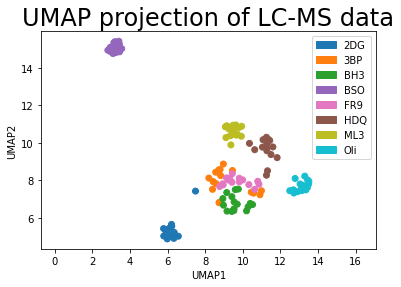

In [105]:
# a kind of complicated way to set up the legend later on. 
#colormap array assigns the listed colors to the respective values in the categories array, 
#every value in categories stands for a inhibitor with its 16 replicates.
categories = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7])
colormap = np.array(["tab:blue","tab:orange","tab:green","tab:purple","tab:pink","tab:brown","tab:olive","tab:cyan"])

#creating a scatterplot of the reduced maxidata with the colors as assigned above
plt.scatter(
    reduced_maxidata[:, 0],
    reduced_maxidata[:, 1],
    c=colormap[categories]
    )

#define variables for the legend of the plot
a = mpatches.Patch(color='tab:blue', label='2DG')
b = mpatches.Patch(color='tab:orange', label='3BP')
c = mpatches.Patch(color='tab:green', label='BH3')
d = mpatches.Patch(color='tab:purple', label='BSO')
e = mpatches.Patch(color='tab:pink', label='FR9')
f = mpatches.Patch(color='tab:brown', label='HDQ')
g = mpatches.Patch(color='tab:olive', label='ML3')
h = mpatches.Patch(color='tab:cyan', label='Oli')

#set up the legend at the best location inside the plot
#As the location of clusters slightly changes with each complete run of the script I did not define an exact location
plt.legend(handles=[a,b,c,d,e,f,g,h], loc=0)

plt.gca().set_aspect('equal', 'datalim')

#define plot title and axes labels
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title('UMAP projection of LC-MS data', fontsize=24)

plt.show()

The result is a scatterplot which shows more or less clear clusters for each inhibitor treatment. some cluster, like 2DG, Oli, ML3 and HDQ are distinct from the others, while the clusters for FR9, BH3 and 3BP are less distinct from each other. The BSO cluster is far away from all others, indicating a very distinct metabolic fingerprint.
With information about the assumed or confirmed pathways targeted by each inhibitor, the clustering could be interpreted more thoroughly. 

Another effort that could be made is assigning different shapes for the points in the scatterplot, so that the batch number can be distinguished in the plot. This would be useful as the results of LC-MS measurements is highly dependent on speed and accuracy of sample preperation, resulting in batch effects. 

The clustering in the UMAP projection is much more distinct than in PCA, as PCA is not as sensitive to certain factors. The clustering with tSNE looked better, as clusters were more distinct, but tSNE is said to be prone to bias, and cherry picking of the clustering that most resembles the users expectations is fairly easy. 

